In [1]:
import os
import json
import math
import h5py
import random
from glob import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [2]:
observations = pd.read_csv('data/n100_final_data.csv', parse_dates=['date'])
covariates = pd.read_csv('data/covariates_env.csv', parse_dates=['date'])

stations = ['ABZ', 'ALE', 'AMA', 'AMM', 'ASP', 'BEI', 'BOT', 'BSL', 'DEL', 'EGB',
            'FKL', 'HAD', 'HEL', 'HPB', 'HRW', 'HYY', 'KCE', 'KPZ', 'MAR', 'MHD', 
            'MLP', 'MUK', 'NAN', 'NEU', 'POV', 'SAO', 'SCH', 'SGP', 'UAE', 'PRL',
            'VAR', 'VHL', 'VIE', 'WAL', 'ZOT']

observations = observations[observations.station.isin(stations)]
observations = observations.sort_values(by=['station', 'date'])
covariates = covariates[covariates.station.isin(stations)]

observations.reset_index(inplace=True, drop=True)
covariates.reset_index(inplace=True, drop=True)

aerosols = ['aermr01', 'aermr02', 'aermr03', 'aermr04', 'aermr05', 'aermr06', 
            'aermr07', 'aermr08', 'aermr09', 'aermr10', 'aermr11']

gases = ['co', 'c5h8', 'c10h16', 'nh3', 'no', 'no2', 'so2']

met = ['d2m', 't2m', 'blh', 'rh', 'wind_speed', 'crwc']
        
loc = ['latitude', 'longitude', 'altitude']

env_types = ['env_type_coastal', 'env_type_remote', 'env_type_rural', 'env_type_rural_regional_background', 'env_type_urban', 'env_type_urban_background']

feature_list = gases + met + aerosols + loc + env_types

log_transform = aerosols + gases + met

# log-transforming the selected variables, setting negative values to the minimum observed positive value
for v in log_transform:
    covariates[v] = np.log(covariates[v].where(covariates[v] > 0, covariates[v][covariates[v] > 0].min()))

observations['n100'] = np.log(observations['n100'])

In [3]:
observations.head()

,date,station,n100,interpolated
0,2012-01-26 17:30:00,ABZ,7.995441,False
1,2012-01-26 18:29:00,ABZ,7.921790,False
2,2012-01-26 19:30:00,ABZ,8.089513,False
3,2012-01-26 20:30:00,ABZ,8.010957,False
4,2012-01-26 21:29:00,ABZ,7.834155,False


In [4]:
covariates.head()

,Unnamed: 0,station,date,latitude,longitude,aermr01,aermr02,aermr03,aermr04,aermr05,...,rh,wind_speed,altitude,environment_type,env_type_coastal,env_type_remote,env_type_rural,env_type_rural_regional_background,env_type_urban,env_type_urban_background
0,0,ABZ,2012-01-01 00:00:00,50.57,12.99,-25.355977,-20.909174,-22.343819,-28.333114,-27.757818,...,4.577019,0.870687,545,urban_background,0,0,0,0,0,1
1,1,ABZ,2012-01-01 03:00:00,50.57,12.99,-25.189441,-20.742743,-21.742577,-27.741422,-27.222011,...,4.585559,0.926574,545,urban_background,0,0,0,0,0,1
2,2,ABZ,2012-01-01 06:00:00,50.57,12.99,-24.923867,-20.477188,-21.259371,-27.626435,-27.201714,...,4.580274,1.021532,545,urban_background,0,0,0,0,0,1
3,3,ABZ,2012-01-01 09:00:00,50.57,12.99,-25.046023,-20.600007,-21.084985,-28.082914,-27.757033,...,4.559845,1.249981,545,urban_background,0,0,0,0,0,1
4,4,ABZ,2012-01-01 12:00:00,50.57,12.99,-25.559982,-21.119738,-21.752305,-28.977890,-28.543334,...,4.535965,1.344619,545,urban_background,0,0,0,0,0,1


In [5]:
observations = observations.dropna(axis=0)
observations.reset_index(inplace=True, drop=True)

In [6]:
# calculate time difference between consecutive rows
observations['time_diff'] = observations.groupby('station')['date'].diff()

# calculate mode time difference for each station
mode_diff = observations.groupby('station')['time_diff'].apply(lambda x: x.mode().iloc[0])

# function to find rows where time difference is greater than mode time difference
def find_gaps(group):
    station = group.name
    return group['time_diff'] > pd.Timedelta(hours=1) + mode_diff[station]

gap_rows = observations.groupby('station').apply(find_gaps).reset_index(level=0, drop=True)

# create a new segment every time a gap is detected
segment_ids = gap_rows.groupby(observations['station']).cumsum()

# Reset the index on segment_ids
segment_ids = segment_ids.reset_index(level=0, drop=True)

# create group_ids column by concatenating station name and segment_ids
observations['group_ids'] = observations['station'] + '_segment_' + segment_ids.astype(str)

observations = observations[['date', 'n100', 'station', 'group_ids']]

In [7]:
observations.groupby('station')['group_ids'].nunique()

station
ABZ     619
ALE     501
AMA     116
AMM      27
ASP      73
BEI     139
BOT     100
BSL      20
DEL      78
EGB      26
FKL      23
HAD      98
HEL     141
HPB      54
HRW      74
HYY     230
KCE     281
KPZ     194
MAR      93
MHD      59
MLP     123
MUK     511
NAN      92
NEU      63
POV     268
PRL      46
SAO      41
SCH     164
SGP    1363
UAE      34
VAR     319
VHL      22
VIE      44
WAL      50
ZOT      18
Name: group_ids, dtype: int64

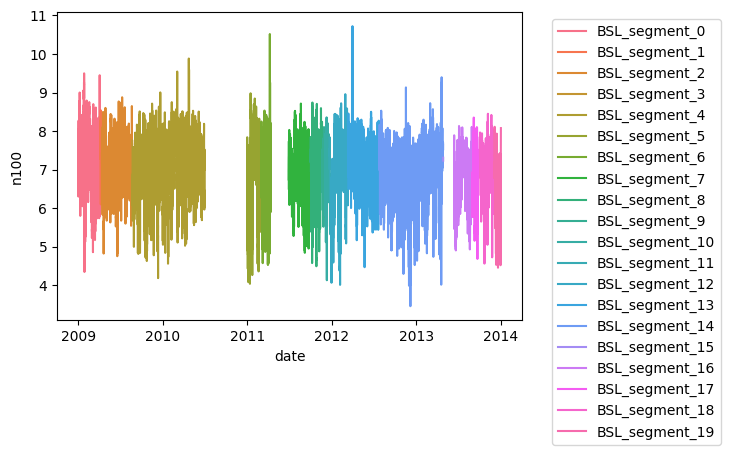

In [8]:
# Filter the data for station ZOT
filtered_data = observations[observations.station == 'BSL']

# Create the plot
plt.figure(figsize=(6, 4))
sns.lineplot(data=filtered_data, x='date', y='n100', hue='group_ids')

# Place the legend to the right of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [9]:
# group by station and group_ids, and calculate the time span of each segment in hours
segment_lengths = observations.groupby(['station', 'group_ids'])['date'].apply(lambda x: (x.max() - x.min()).total_seconds() / 3600)

# calculate time difference between consecutive rows
time_diff = observations.groupby('station')['date'].diff()

# filter for rows where time difference is greater than 3 hours
gap_lengths = time_diff[time_diff > pd.Timedelta(hours=1, minutes=5)]

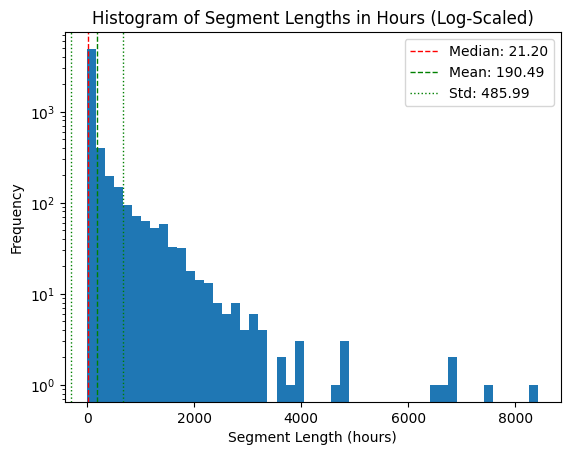

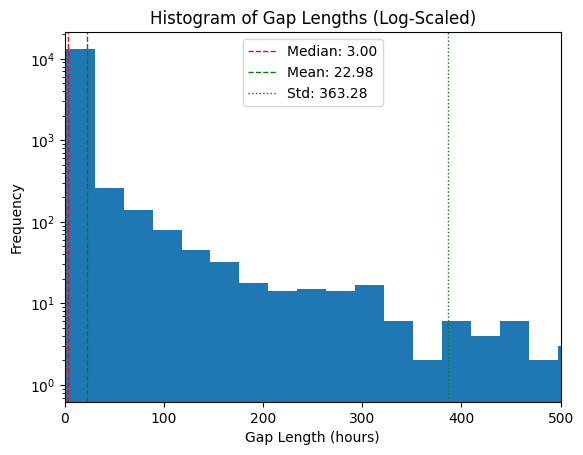

In [10]:
# calculate median, mean, and std for segment lengths in hours
segment_median = np.median(segment_lengths)
segment_mean = np.mean(segment_lengths)
segment_std = np.std(segment_lengths)

# create histogram of segment lengths with median, mean, and std plotted
plt.hist(segment_lengths, bins=50, log=True)
plt.xlabel('Segment Length (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Segment Lengths in Hours (Log-Scaled)')
plt.axvline(segment_median, color='r', linestyle='dashed', linewidth=1)
plt.axvline(segment_mean, color='g', linestyle='dashed', linewidth=1)
plt.axvline(segment_mean + segment_std, color='g', linestyle='dotted', linewidth=1)
plt.axvline(segment_mean - segment_std, color='g', linestyle='dotted', linewidth=1)
plt.legend(['Median: {:.2f}'.format(segment_median), 'Mean: {:.2f}'.format(segment_mean), 'Std: {:.2f}'.format(segment_std)])
plt.show()
# calculate median, mean, and std for gap lengths
gap_median = np.median(gap_lengths / pd.Timedelta(hours=1))
gap_mean = np.mean(gap_lengths / pd.Timedelta(hours=1))
gap_std = np.std(gap_lengths / pd.Timedelta(hours=1))

# create histogram of gap lengths with median, mean, and std plotted
plt.hist(gap_lengths / pd.Timedelta(hours=1), bins=1000, log=True)
plt.xlabel('Gap Length (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Gap Lengths (Log-Scaled)')
plt.axvline(gap_median, color='r', linestyle='dashed', linewidth=1)
plt.axvline(gap_mean, color='g', linestyle='dashed', linewidth=1)
plt.axvline(gap_mean + gap_std, color='g', linestyle='dotted', linewidth=1)
plt.axvline(gap_mean - gap_std, color='g', linestyle='dotted', linewidth=1)
plt.legend(['Median: {:.2f}'.format(gap_median), 'Mean: {:.2f}'.format(gap_mean), 'Std: {:.2f}'.format(gap_std)])
plt.xlim([0, 500])
plt.show()

In [11]:
# group by station and group_ids, and calculate the time span of each segment in hours
segment_lengths = observations.groupby(['station', 'group_ids'])['date'].apply(lambda x: (x.max() - x.min()).total_seconds() / 3600)

In [12]:
# total number of segments
total_segments = len(segment_lengths)
print(f"Total number of segments: {total_segments}")

# count the number of segments longer than each 24-hour increment up to 240 hours
for i in range(24, 24*11, 24):
    num_segments_longer_than_i = sum(segment_lengths > i)
    print(f"Number of segments longer than {i} hours: {num_segments_longer_than_i}")

Total number of segments: 6104
Number of segments longer than 24 hours: 2685
Number of segments longer than 48 hours: 2195
Number of segments longer than 72 hours: 1885
Number of segments longer than 96 hours: 1660
Number of segments longer than 120 hours: 1502
Number of segments longer than 144 hours: 1387
Number of segments longer than 168 hours: 1241
Number of segments longer than 192 hours: 1151
Number of segments longer than 216 hours: 1097
Number of segments longer than 240 hours: 1045


In [ ]:
pd.options.mode.chained_assignment = None

# Define the sequence length
min_gap_size = 1
max_gap_size = 120 # 5 days
sequence_length = pd.Timedelta(hours=168) # 7 days
covariate_size = 2030 # 60 # more than 168h / 3h
observation_size = 2030 # more than 168h / 5 minutes
dir_name = 'granular_data_env'

os.makedirs(dir_name, exist_ok=True)

def create_gaps(seq, gap_size):
    # Ensure the gap doesn't start at the first element or end at the last
    start = np.random.randint(1, len(seq) - gap_size - 1)
    end = start + gap_size
    mask = np.ones(len(seq), dtype=bool)
    mask[start:end] = False
    return mask

for group_id in tqdm(observations.group_ids.unique()):
    group_data = observations[observations.group_ids == group_id].copy()
    station = group_id.split('_')[0]
    
    # Exclude groups shorter than sequence_length
    if group_data['date'].max() - group_data['date'].min() < sequence_length:
        continue
    
    # Define the timedelta in terms of number of observations
    average_interval = group_data['date'].diff().mean()
    obs_per_hour = int(round(pd.Timedelta(hours=1) / average_interval))
    
    # Loop over sequences within the group
    start_date = group_data['date'].min()
    end_date = start_date + sequence_length
    split_index = 0
    
    # Sliding window for sequences within the group
    with h5py.File(f'{dir_name}/{group_id}.hdf5', 'w') as h5file:       
        while end_date <= group_data['date'].max():
            split_data = group_data[(group_data['date'] >= start_date) & (group_data['date'] < end_date)].copy()
        
            # For every split_data take covariates in +/- 3 hour range of min and max date
            station_covariates = covariates[covariates.station == station]
            covariate_data = station_covariates[
                  (station_covariates['date'] >= (split_data.date.min() - pd.Timedelta(hours=3))) 
                & (station_covariates['date'] <= (split_data.date.max() + pd.Timedelta(hours=3)))]

            if covariate_data.size < 12:
                print(f'{group_id}_{split_index} lack covariates')
                split_index += 1
                start_date += pd.Timedelta(hours=24)
                end_date = start_date + sequence_length
                continue

            # Create a gap with size randomly chosen between one hour and 120 hours (5 days)
            low = max(min_gap_size, obs_per_hour)
            high = max_gap_size*obs_per_hour
            if low > high:
                print(f'{group_id}_{split_index} low > high gap size')
                split_index += 1
                start_date += pd.Timedelta(hours=24)
                end_date = start_date + sequence_length
                continue
            gap_size = np.random.randint(low=low, high=high)
            split_data['mask'] = create_gaps(split_data['n100'], gap_size)

            # Interpolate 'n100' in the gap using time method
            split_data.set_index('date', inplace=True)
            split_data['target'] = split_data['n100']
            split_data.loc[~split_data['mask'], 'n100'] = np.nan
            split_data['interpolated_target'] = split_data['n100'].interpolate(method='time')
            split_data.reset_index(inplace=True)
            split_data.rename(columns={'index': 'date'}, inplace=True)

            assert len(split_data) <= observation_size, f'split_data has {len(split_data)} rows before padding'

            # Pad observations
            split_data.loc[:, 'padded'] = False
            pad_size = max(0, observation_size - len(split_data))
            if pad_size > 0:
                last_row = split_data.tail(1)
                padding_df = pd.concat([last_row]*pad_size, ignore_index=True)
                padding_df.loc[:,'padded'] = True
                split_data = pd.concat([split_data, padding_df], ignore_index=True)

            # Pad covariates
            covariate_data.loc[:, 'padded'] = False
            pad_size = max(0, covariate_size - len(covariate_data))
            if pad_size > 0:
                last_row = covariate_data.tail(1)
                padding_df = pd.concat([last_row]*pad_size, ignore_index=True)
                padding_df.loc[:,'padded'] = True
                covariate_data = pd.concat([covariate_data, padding_df], ignore_index=True)
            
            observation_data = split_data[['date', 'interpolated_target', 'target', 'mask', 'padded']]
            covariate_data = covariate_data[['date', 'padded'] + feature_list]

            # Convert 'date' column to Unix time (number of seconds since 1970-01-01 00:00:00)
            observation_data['date'] = observation_data['date'].map(pd.Timestamp.timestamp)
            covariate_data['date'] = covariate_data['date'].map(pd.Timestamp.timestamp)

            # Convert booleans to int
            observation_data = observation_data.astype({'mask': 'int', 'padded': 'int'})
            covariate_data = covariate_data.astype({'padded': 'int'})
            
            # Save to file
            h5file.create_dataset(f'{split_index}/observations', data=observation_data)
            h5file.create_dataset(f'{split_index}/covariates', data=covariate_data)
            
            split_index += 1
            start_date += pd.Timedelta(hours=24)
            end_date = start_date + sequence_length

  0%|          | 0/6104 [00:00<?, ?it/s]

BEI_segment_50_0 lack covariates
BEI_segment_50_1 lack covariates
BEI_segment_50_2 lack covariates
BEI_segment_50_3 lack covariates
BEI_segment_50_4 lack covariates
BEI_segment_50_5 lack covariates
BEI_segment_50_6 lack covariates
BEI_segment_53_0 lack covariates
BEI_segment_53_1 lack covariates
BEI_segment_53_2 lack covariates
BEI_segment_88_0 lack covariates
BEI_segment_91_0 lack covariates
BEI_segment_91_1 lack covariates
BEI_segment_91_2 lack covariates
BEI_segment_91_3 lack covariates
BEI_segment_91_4 lack covariates
BEI_segment_91_5 lack covariates
BEI_segment_91_6 lack covariates
BEI_segment_91_7 lack covariates
BEI_segment_91_8 lack covariates
BEI_segment_91_9 lack covariates
BEI_segment_91_10 lack covariates
BEI_segment_91_11 lack covariates
BEI_segment_91_12 lack covariates
BEI_segment_92_0 lack covariates
BEI_segment_92_1 lack covariates
BEI_segment_92_2 lack covariates
BEI_segment_92_3 lack covariates
BEI_segment_92_4 lack covariates
BEI_segment_92_5 lack covariates
BEI_seg

In [ ]:
data_splits = [0.8, 0.1, 0.1]

# Group files by station
files_by_station = defaultdict(list)
for f in os.scandir(dir_name):
    if f.is_file() and f.name.endswith('.hdf5'):
        station = f.name.split('_')[0]
        files_by_station[station].append(f.path)

# Shuffle the files within each station and split according to data_splits
train_files = []
val_files = []
test_files = []
random.seed(42)
for station, files in files_by_station.items():
    random.shuffle(files)
    train_ratio, val_ratio = data_splits[:2]
    train_split = int(train_ratio * len(files))
    val_split = train_split + int(val_ratio * len(files))
    train_files.extend(files[:train_split])
    val_files.extend(files[train_split:val_split])
    test_files.extend(files[val_split:])

In [ ]:
def get_data_paths(flist):
    ds = []
    for f in tqdm(flist):
        with h5py.File(f, 'r') as h5file:
            for key in h5file.keys():
                ds.append((f, key))
    return ds

train_paths = get_data_paths(train_files)
val_paths = get_data_paths(val_files)
test_paths = get_data_paths(test_files)

In [ ]:
data_paths = {
    'train': train_paths,
    'val': val_paths,
    'test': test_paths
}

with open(os.path.join(dir_name, 'paths.json'), 'w') as f:
    json.dump(data_paths, f, indent=2)